<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('bmh')
pd.set_option('display.max_columns', 100)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## Step 1: EDA 

### Data Cleaning

In [2]:
# Load the data
house = pd.read_csv('./housing.csv', index_col='Id')

In [3]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house.shape

(1460, 80)

In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [6]:
# Check the zoning classification.
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [7]:
# Remove any houses that are not residential (C).
idx = house[house['MSZoning'] == 'C (all)'].index
house.drop(idx, inplace=True)

In [8]:
# Check number of missing values.
house.isnull().sum().sort_values(ascending=False)[:19]

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageType        79
GarageCond        79
GarageFinish      79
GarageQual        79
GarageYrBlt       79
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [9]:
# Drop the row containing one missing value for "Electrical".
house.drop(house[house['Electrical'].isnull()].index, inplace=True)

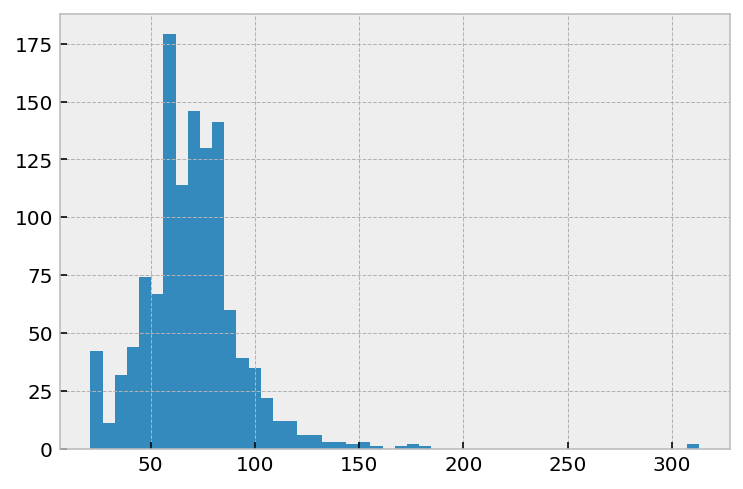

In [10]:
# Check the distribution for continuous data.
house['LotFrontage'].hist(bins=50)
plt.show()

In [11]:
# Fillna for numerical columns.
house['LotFrontage'].fillna(house['LotFrontage'].median(), inplace=True)
house['MasVnrArea'].fillna(0, inplace=True)
house['GarageYrBlt'].fillna(house['YearBuilt'], inplace=True)

In [12]:
# Fill missing value for categorical columns.
house.fillna('NA', inplace=True)

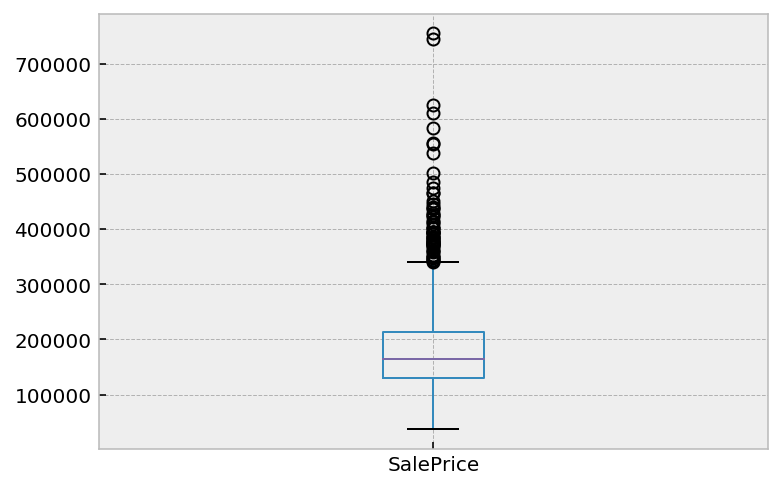

In [13]:
# Check outliers for depedent variable.
house['SalePrice'].plot.box()
plt.show()

In [14]:
# Filter out outliers in dependent variable.
quartiles = np.percentile(house['SalePrice'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])
df = house.query('(SalePrice > @mu - 5 * @sig) & (SalePrice < @mu + 5 * @sig)')
print(house.shape, df.shape)

(1449, 80) (1438, 80)


### Explore correlation between continuous variables and SalePrice

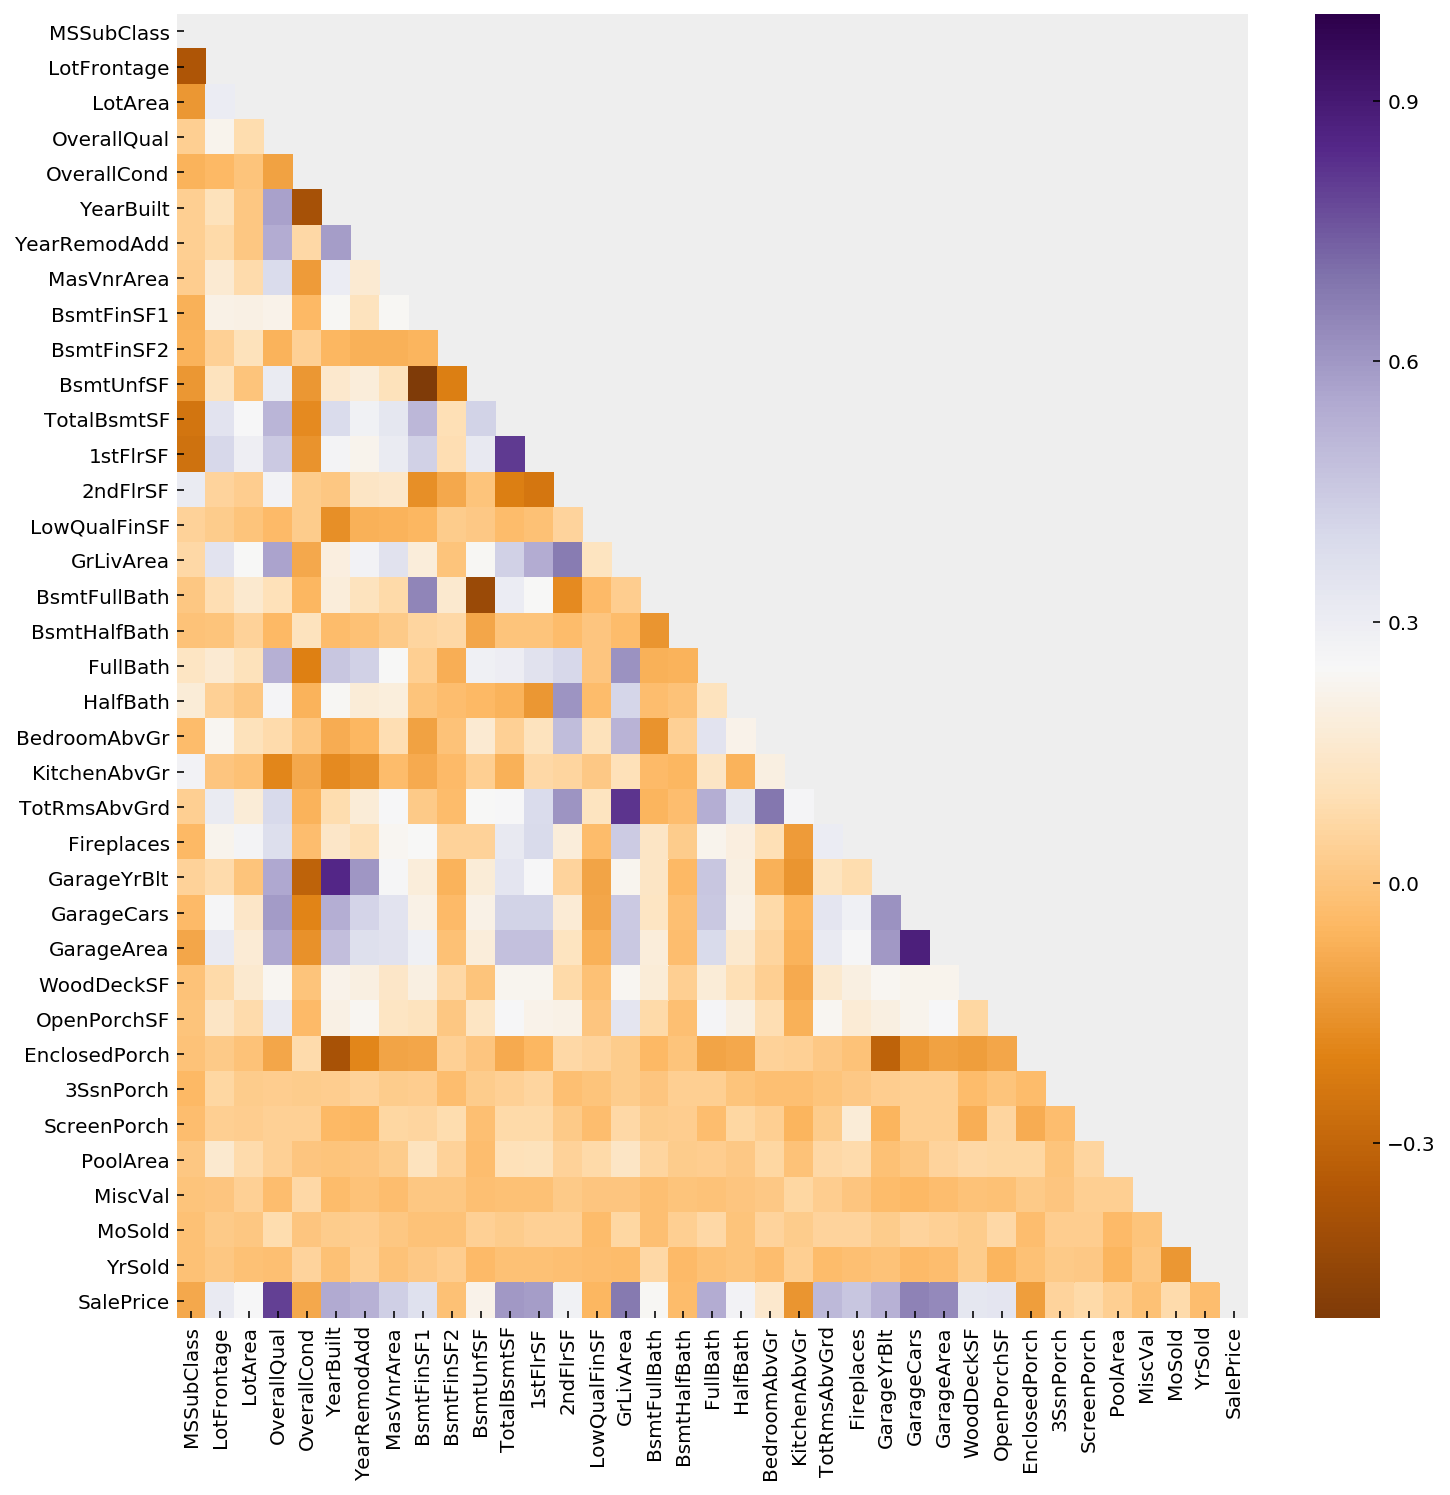

In [15]:
# Create masked correlation matrix.
def correlation_heat_map(df): 
    corrs = df.corr()
    fig, ax = plt.subplots(figsize=(12,12)) 
    
    mask = np.zeros_like(corrs, dtype=np.bool) 
    mask[np.triu_indices_from(mask)] = True
    
    ax = sns.heatmap(corrs, mask=mask, cmap='PuOr') 

    ax.set_xticklabels(ax.xaxis.get_ticklabels()) 
    ax.set_yticklabels(ax.yaxis.get_ticklabels()) 
    plt.show()

correlation_heat_map(df)

In [16]:
# Rank parameters based on correlation with SalePrice.
abs(df.corr(method='spearman')['SalePrice']).sort_values(ascending=False)[1:]

OverallQual      0.803242
GrLivArea        0.726244
GarageCars       0.686818
YearBuilt        0.647848
GarageArea       0.647457
FullBath         0.626225
GarageYrBlt      0.607731
TotalBsmtSF      0.593075
1stFlrSF         0.563984
YearRemodAdd     0.562928
TotRmsAbvGrd     0.523299
Fireplaces       0.508297
OpenPorchSF      0.475333
LotArea          0.448345
MasVnrArea       0.404132
LotFrontage      0.379093
WoodDeckSF       0.350318
HalfBath         0.334306
BsmtFinSF1       0.295348
2ndFlrSF         0.286854
BedroomAbvGr     0.223379
BsmtFullBath     0.221301
EnclosedPorch    0.205881
BsmtUnfSF        0.185495
KitchenAbvGr     0.166325
OverallCond      0.140112
ScreenPorch      0.088105
MoSold           0.081114
LowQualFinSF     0.072310
3SsnPorch        0.067050
MiscVal          0.052029
PoolArea         0.045667
BsmtFinSF2       0.042927
YrSold           0.027987
BsmtHalfBath     0.015115
MSSubClass       0.003505
Name: SalePrice, dtype: float64

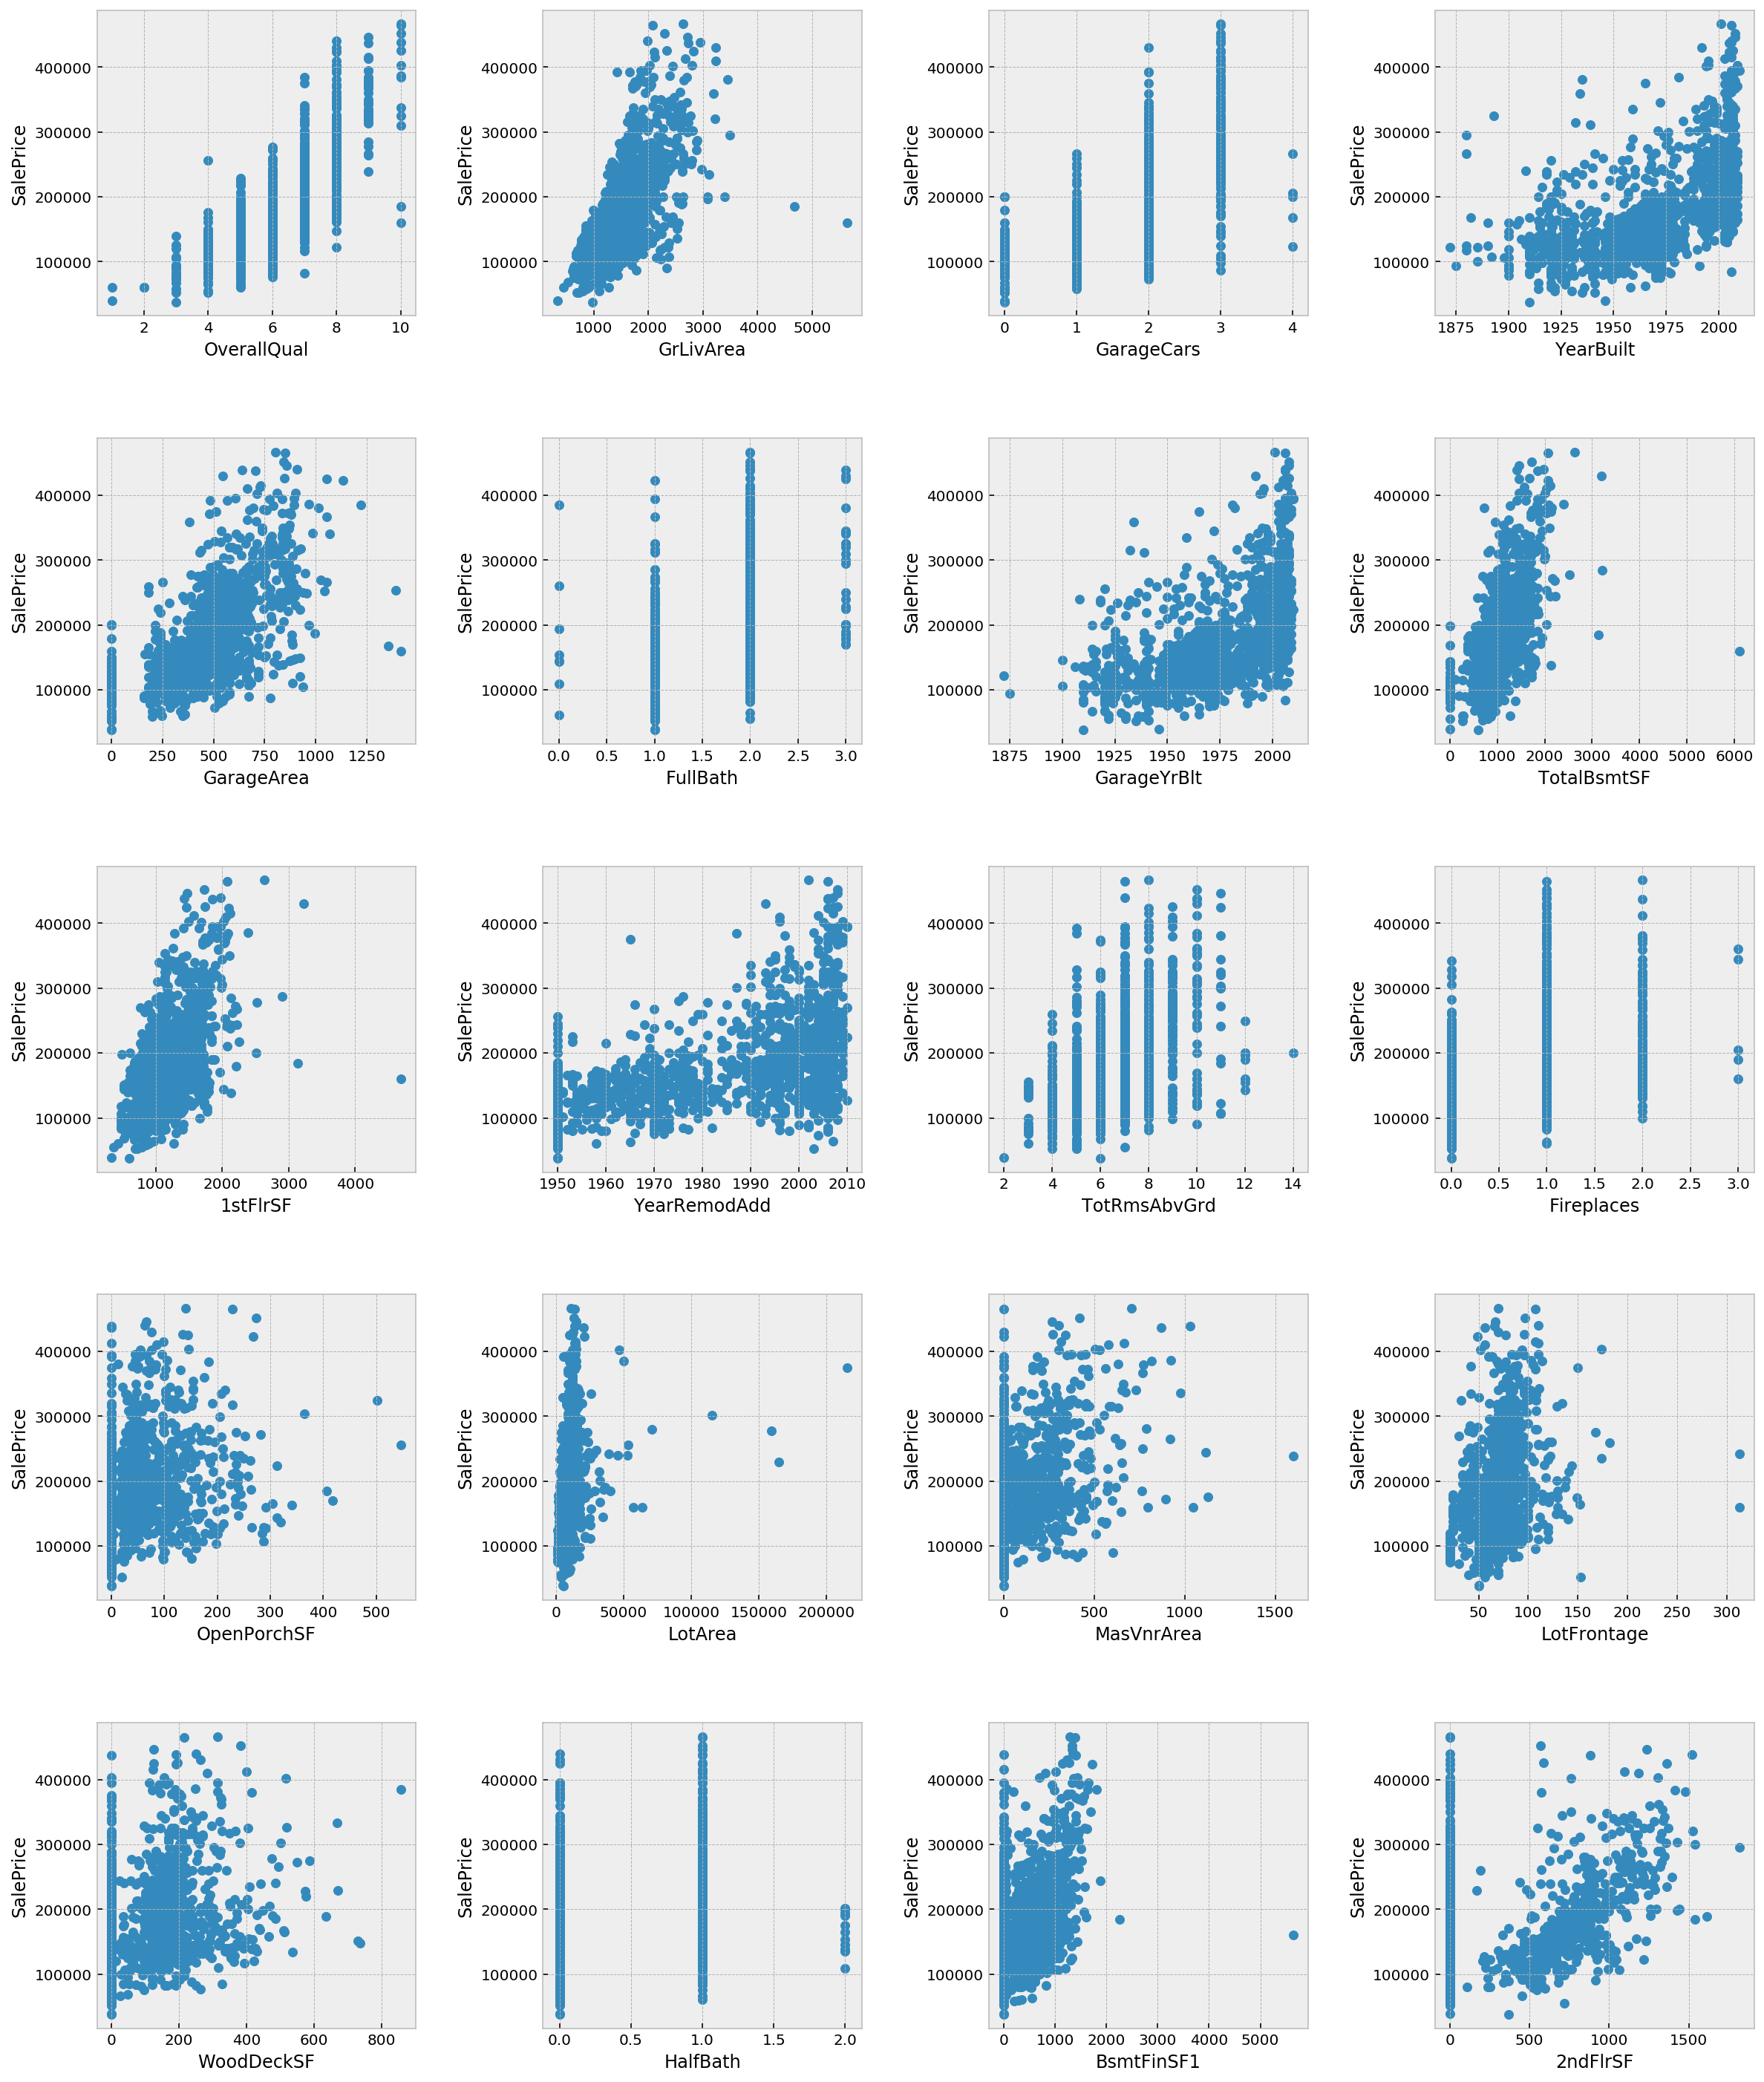

In [17]:
# Plot the first 20 parameters.
columns = abs(df.corr(method='spearman')['SalePrice']).sort_values(ascending=False)[1:21].index.values
fig = plt.figure(figsize=(20,25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 21):
    ax = fig.add_subplot(5, 4, i)
    ax.scatter(x=columns[i-1], y='SalePrice', data=df)
    ax.set_xlabel(columns[i-1])
    ax.set_ylabel('SalePrice')

### Explore correlation between categorical variables and SalePrice

In [18]:
# Calculate point biserial correlation coefficient.
categorical = df.select_dtypes('object').columns.values

values = []
for c in categorical:
    factorized = pd.factorize(df[c])[0]
    corr = stats.pointbiserialr(factorized, df['SalePrice'])[0]
    values.append(corr)

pd.Series(values, index=categorical).abs().sort_values(ascending=False)

Foundation       0.452670
HeatingQC        0.438192
FireplaceQu      0.409847
BsmtFinType1     0.382900
ExterQual        0.334468
GarageType       0.279423
GarageQual       0.266588
LotShape         0.262813
CentralAir       0.256199
Electrical       0.236963
GarageCond       0.234034
PavedDrive       0.214005
HouseStyle       0.200438
Exterior2nd      0.191142
KitchenQual      0.190353
BsmtCond         0.174881
Neighborhood     0.155489
MSZoning         0.153844
RoofStyle        0.147480
Fence            0.144171
SaleCondition    0.141088
BsmtQual         0.138261
Functional       0.135532
BsmtExposure     0.132673
ExterCond        0.132395
Exterior1st      0.131132
Heating          0.115415
BldgType         0.113276
LandContour      0.110459
LotConfig        0.091934
Alley            0.087050
BsmtFinType2     0.084890
SaleType         0.066738
LandSlope        0.063225
MiscFeature      0.055161
Condition1       0.045548
GarageFinish     0.041305
RoofMatl         0.028819
PoolQC      

## 2. Build Model

### Define independent and dependent variables

In [19]:
# Identify characteristics of the house that cannot be renovated.
no_renovate = [
    'LotFrontage', 'LotArea', 'LotShape', 
    'Neighborhood', 'BldgType', 'HouseStyle', 
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBsmtSF', 
    '1stFlrSF', '2ndFlrSF', 'GrLivArea', 
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
    'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
    'TotRmsAbvGrd', 'Fireplaces', 
    'GarageType', 'GarageYrBlt', 'GarageCars',
    'GarageArea', 'PavedDrive',
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal', 
    'YrSold', 'SalePrice'
]

In [20]:
# Create dummy variables for all categorical columns.
df_nr = df[no_renovate]
for item in no_renovate:
    if item in categorical:
        dummies = pd.get_dummies(df_nr[item], prefix=item, drop_first=True, dtype=int)
        df_nr = pd.concat([df_nr, dummies], axis=1)
        df_nr.drop(item, axis=1, inplace=True)

In [21]:
df_nr.shape

(1438, 92)

In [22]:
# Create independent and dependent variables.
X_train = df_nr.query('YrSold < 2010').drop(['YrSold', 'SalePrice'], axis=1)
X_test = df_nr.query('YrSold >= 2010').drop(['YrSold', 'SalePrice'], axis=1)
y_train = np.log(df_nr.query('YrSold < 2010')['SalePrice'])
y_test = np.log(df_nr.query('YrSold >= 2010')['SalePrice'])

print(X_train.shape, y_train.shape, X_test.shape,  y_test.shape)

(1268, 90) (1268,) (170, 90) (170,)


### Multiple Linear Regression Model with defined parameters

In [23]:
# Calculate p-value by statsmodels.
X_train_ols = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     88.74
Date:                Tue, 15 Jan 2019   Prob (F-statistic):               0.00
Time:                        11:44:49   Log-Likelihood:                 733.94
No. Observations:                1268   AIC:                            -1286.
Df Residuals:                    1177   BIC:                            -817.7
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.3088      1.008      4.274      0.000       2.331       6.287
LotFrontage             -0.0007      0.000     -2.822      0.005      -0.001      -0.000
LotArea                 1.2e-06   4.97e-07      2.415      0.016    2.25e-07    2.17e-06
YearBuilt                0.0011      0.000      2.407      0.016       0.000       0.002
YearRemodAdd             0.0026      0.000      9.158      0.000       0.002       0.003
MasVnrArea           -1.754e-05   2.86e-05     -0.613      0.540   -7.37e-05    3.86e-05
TotalBsmtSF           2.199e-05   2.55e-05      0.861      0.389   -2.81e-05    7.21e-05
1stFlrSF                 0.0001      0.000      0.844      0.399      -0.000       0.000
2ndFlrSF                 0.0001      0.000      1.113      0.266   -9.85e-05       0.000
GrLivArea                0.0001      0.000      0.926      0.355      -0.000       0.000
BsmtFullBath             0.0602      0.009      6.443      0.000       0.042       0.079
BsmtHalfBath             0.0315      0.017      1.826      0.068      -0.002       0.065
FullBath                 0.0480      0.013      3.604      0.000       0.022       0.074
HalfBath                 0.0298      0.013      2.329      0.020       0.005       0.055
BedroomAbvGr             0.0048      0.008      0.579      0.563      -0.011       0.021
KitchenAbvGr            -0.1135      0.033     -3.490      0.001      -0.177      -0.050
TotRmsAbvGrd             0.0135      0.006      2.258      0.024       0.002       0.025
Fireplaces               0.0472      0.008      5.695      0.000       0.031       0.063
GarageYrBlt             -0.0003      0.000     -0.946      0.344      -0.001       0.000
GarageCars               0.0605      0.014      4.395      0.000       0.033       0.087
GarageArea            2.596e-05   4.88e-05      0.532      0.595   -6.98e-05       0.000
WoodDeckSF               0.0001   3.72e-05      3.541      0.000    5.87e-05       0.000
OpenPorchSF              0.0001   7.02e-05      1.928      0.054   -2.42e-06       0.000
EnclosedPorch            0.0002   7.62e-05      2.032      0.042     5.3e-06       0.000
3SsnPorch                0.0004      0.000      2.875      0.004       0.000       0.001
ScreenPorch              0.0003   7.86e-05      4.357      0.000       0.000       0.000
PoolArea                -0.0002      0.000     -1.424      0.155      -0.000    6.15e-05
MiscVal               3.078e-05   2.61e-05      1.180      0.238   -2.04e-05    8.19e-05
LotShape_IR2             0.0402      0.027      1.495      0.135      -0.013       0.093
LotShape_IR3            -0.1115      0.050     -2.237      0.025      -0.209      -0.014
LotShape_Reg             0.0014      0.010      0.148      0.882      -0.017       0.020
Neighborhood_Blueste    -0.1149      0.109     -1.050    

### Feature selection

In [24]:
# Create class for backward selection.
class BackwardSelection():
    """
    Backward selection using statsmodels.

    Attributes
    ----------
    parameters_ : array, shape (n_features, )
        Parameters remained after backward selection.
    """
    
    def __init__(self):
        self.parameters_ = None
        
    def fit(self, X, y, SL):
        """
        Perform backward selection.
        """
        X_ols = sm.add_constant(X)
        model = sm.OLS(y, X_ols).fit()
        max_p = model.pvalues.max()

        columns = X.columns.values

        while max_p > SL:
            idx_p = np.argmax(model.pvalues.values)
            X_ols = X_ols.drop(X_ols.columns[idx_p], axis=1)
            columns = np.delete(columns, (idx_p - 1))
            model = sm.OLS(y, X_ols).fit()
            max_p = model.pvalues.max()    
            
        self.parameters_ = columns
        print(model.summary())

In [25]:
model = BackwardSelection()
model.fit(X_train, y_train, 0.05)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     179.7
Date:                Tue, 15 Jan 2019   Prob (F-statistic):               0.00
Time:                        11:44:49   Log-Likelihood:                 707.17
No. Observations:                1268   AIC:                            -1324.
Df Residuals:                    1223   BIC:                            -1093.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.5537 

In [26]:
model.parameters_

array(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', '1stFlrSF',
       '2ndFlrSF', 'BsmtFullBath', 'FullBath', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'LotShape_IR3', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_Sawyer',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Neighborhood_Veenker', 'BldgType_Twnhs', 'BldgType_TwnhsE',
       'HouseStyle_2Story', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA',
       'BsmtExposure_Gd', 'BsmtExposure_NA', 'BsmtExposure_No',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_Detchd', 'GarageType_NA', 'PavedDrive_Y'], dtype=object)

In [27]:
# Build linear model using above variables by sklearn.
X_train = X_train[model.parameters_]
X_test = X_test[model.parameters_]

In [28]:
# Calculate adjusted R-squared.
def r2_adjusted(X, y):
    """
    Calculate adjusted R-squared for multiple linear regression model.
    """
    lr = LinearRegression()
    r2 = lr.fit(X, y).score(X, y)
    r2_adjusted = 1 - (1-r2)*(X.shape[0]-1) / (X.shape[0]-X.shape[1]-1)
    return r2_adjusted

In [29]:
print('Training score: ', r2_adjusted(X_train, y_train))
print('Test score: ', r2_adjusted(X_test, y_test))

Training score:  0.8611912162556284
Test score:  0.8914655508846276


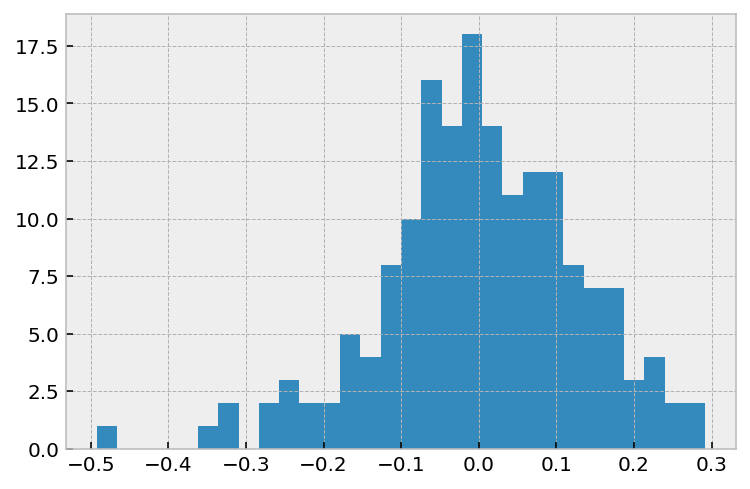

In [30]:
# The residual is approximately normal distribution.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
residual = y_test - y_pred
residual.hist(bins=30)
plt.show()

### Feature Engineering

In [31]:
# Create new columns for training and test set.
X2_train = X_train.copy()
X2_train['YearBuilt_YearRemodAdd'] = X2_train['YearBuilt']*X2_train['YearRemodAdd']
X2_train['YearBuilt_squared'] = X2_train['YearBuilt']**2

X2_test = X_test.copy()
X2_test['YearBuilt_YearRemodAdd'] = X2_test['YearBuilt']*X2_test['YearRemodAdd']
X2_test['YearBuilt_squared'] = X2_test['YearBuilt']**2

In [32]:
# Refit the model and evaluate the R-squared.
lr = LinearRegression()
lr.fit(X2_train, y_train)
print('Training score: ', r2_adjusted(X2_train, y_train))
print('Test score: ', r2_adjusted(X2_test, y_test))

Training score:  0.8614626898398455
Test score:  0.8957600071143872


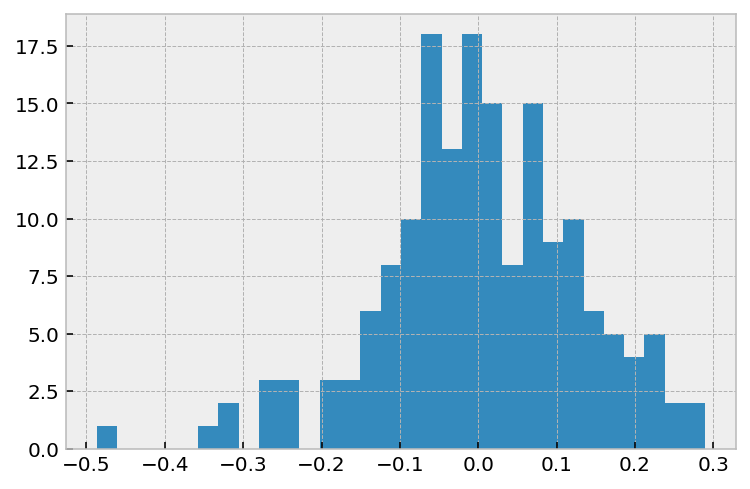

In [33]:
# Predict the results.
y_pred_train = lr.predict(X2_train)
y_pred_test = lr.predict(X2_test)
residual = y_test - y_pred_test
residual.hist(bins=30)
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [34]:
# Establish new DataFrame.
renovate = [
    'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType',
    'ExterQual', 'ExterCond', 'BsmtFinType1', 'BsmtFinType2', 
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtCond',
    'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
    'LowQualFinSF', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 
    'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'YrSold'
]

df_r = df[renovate]

In [35]:
# Map quality / condition variables.
rank = [
    'ExterQual', 'ExterCond', 'BsmtCond', 
    'HeatingQC', 'KitchenQual', 'FireplaceQu', 
    'GarageQual', 'GarageCond', 'PoolQC'
]

s = {
    'NA': -1,
    'Po': 0,
    'Fa': 1,
    'TA': 2,
    'Gd': 3,
    'Ex': 4
}

for column in rank:
    df_r[column] = df_r[column].map(s)

/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
# Create dummy variables.
categorical = df_r.select_dtypes('object').columns.values

for item in categorical:
    dummies = pd.get_dummies(df_r[item], prefix=item, drop_first=True, dtype=int)
    df_r = pd.concat([df_r, dummies], axis=1)
    df_r.drop(item, axis=1, inplace=True)

In [37]:
df_r.shape

(1438, 90)

In [39]:
# Create independent and dependent variables.
X_train = df_r.query('YrSold < 2010').drop(['YrSold'], axis=1)
X_test = df_r.query('YrSold >= 2010').drop(['YrSold'], axis=1)
y_train = y_pred_train
y_test = y_pred_test
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1268, 89) (1268,) (170, 89) (170,)


In [40]:
# Calculate p-value by statsmodels.
X_train_ols = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     62.09
Date:                Tue, 15 Jan 2019   Prob (F-statistic):               0.00
Time:                        11:45:12   Log-Likelihood:                 613.36
No. Observations:                1268   AIC:                            -1051.
Df Residuals:                    1180   BIC:                            -597.9
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.4594      0.306     34.160      0.000       9.859      11.060
OverallQual             0.0825      0.006     13.652      0.000       0.071       0.094
OverallCond            -0.0002      0.005     -0.033      0.974      -0.010       0.009
ExterQual               0.0449      0.014      3.244      0.001       0.018       0.072
ExterCond              -0.0093      0.014     -0.651      0.515      -0.037       0.019
BsmtFinSF1              0.0003   2.02e-05     12.669      0.000       0.000       0.000
BsmtFinSF2              0.0002   5.73e-05      3.464      0.001     8.6e-05       0.000
BsmtUnfSF               0.0002    1.7e-05      9.394      0.000       0.000       0.000
BsmtCond               -0.0046      0.016     -0.279      0.780      -0.037       0.028
HeatingQC               0.0144      0.006      2.289      0.022       0.002       0.027
LowQualFinSF            0.0001   9.87e-05      1.107      0.269   -8.44e-05       0.000
KitchenQual             0.0501      0.011      4.706      0.000       0.029       0.071
FireplaceQu             0.0378      0.003     12.732      0.000       0.032       0.044
GarageQual             -0.0021      0.024     -0.087      0.931      -0.049       0.045
GarageCond              0.0241      0.025      0.959      0.338      -0.025       0.074
PoolQC                 -0.0045      0.021     -0.211      0.833      -0.046       0.037
RoofStyle_Gable        -0.0291      0.119     -0.245      0.807      -0.263       0.204
RoofStyle_Gambrel      -0.0135      0.131     -0.103      0.918      -0.270       0.243
RoofStyle_Hip          -0.0467      0.119     -0.392      0.695      -0.281       0.187
RoofStyle_Mansard       0.0009      0.144      0.007      0.995      -0.281       0.283
RoofStyle_Shed          0.0685      0.200      0.343      0.732      -0.323       0.460
RoofMatl_CompShg        0.5326      0.202      2.641      0.008       0.137       0.928
RoofMatl_Membran        0.4884      0.289      1.689      0.092      -0.079       1.056
RoofMatl_Metal          0.5248      0.287      1.829      0.068      -0.038       1.088
RoofMatl_Roll           0.6691      0.262      2.555      0.011       0.155       1.183
RoofMatl_Tar&Grv        0.5875      0.236      2.492      0.013       0.125       1.050
RoofMatl_WdShake        0.5169      0.229      2.255      0.024       0.067       0.967
RoofMatl_WdShngl        0.5914      0.215      2.755      0.006       0.170       1.013
Exterior1st_AsphShn -1.212e-15   4.73e-16     -2.561      0.011   -2.14e-15   -2.84e-16
Exterior1st_BrkComm    -0.1000      0.163     -0.612      0.541      -0.421       0.220
Exterior1st_BrkFace    -0.0215      0.083     -0.259      0.796      -0.184       0.141
Exterior1st_CBlock     -0.0749      0.083     -0.907      0.365      -0.237       0.087
Ext

In [41]:
# Feature selection
model = BackwardSelection()
model.fit(X_train, y_train, 0.05)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     217.1
Date:                Tue, 15 Jan 2019   Prob (F-statistic):               0.00
Time:                        11:45:20   Log-Likelihood:                 589.42
No. Observations:                1268   AIC:                            -1127.
Df Residuals:                    1242   BIC:                            -993.1
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.2652    

In [42]:
# Calculate adjusted R-squared.
X_train = X_train[model.parameters_]
X_test = X_test[model.parameters_]

lr = LinearRegression()
lr.fit(X_train, y_train)

print('Training score: ', r2_adjusted(X_train, y_train))
print('Test score: ', r2_adjusted(X_test, y_test))

Training score:  0.8100621549376734
Test score:  0.8282256372847557


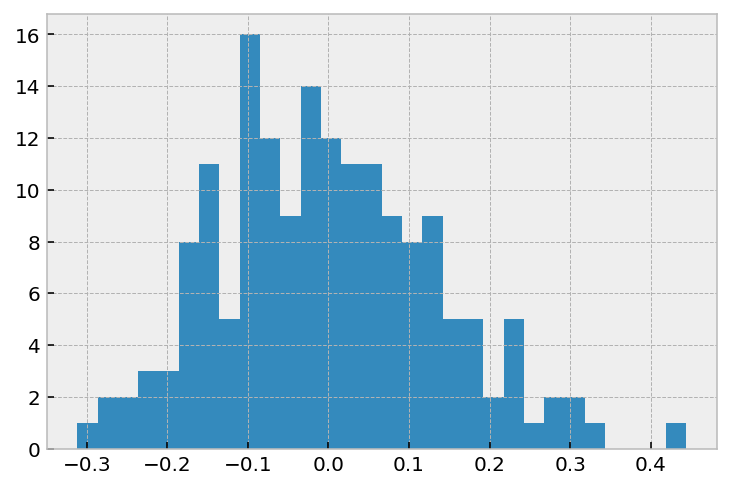

In [52]:
# Predict the results.
y_pred = lr.predict(X_test)
residual = y_test - y_pred
plt.hist(residual, bins=30)
plt.show()

In [53]:
# Feature engineering.
X_train.columns

Index(['OverallQual', 'ExterQual', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'HeatingQC', 'KitchenQual', 'FireplaceQu', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Exterior2nd_BrkFace', 'Exterior2nd_HdBoard', 'Exterior2nd_Plywood',
       'Exterior2nd_VinylSd', 'BsmtFinType1_NA', 'BsmtFinType1_Unf',
       'BsmtFinType2_NA', 'Electrical_SBrkr', 'GarageFinish_NA',
       'GarageFinish_Unf'],
      dtype='object')

In [77]:
# Create new columns for training and test set.
X2_train = X_train.copy()
X2_train['OverallQual_KitchenQual'] = X2_train['OverallQual']*X2_train['KitchenQual']

X2_test = X_test.copy()
X2_test['OverallQual_KitchenQual'] = X2_test['OverallQual']*X2_test['KitchenQual']

In [78]:
# Refit the model and evaluate the R-squared.
lr = LinearRegression()
lr.fit(X2_train, y_train)
print('Training score: ', r2_adjusted(X2_train, y_train))
print('Test score: ', r2_adjusted(X2_test, y_test))

Training score:  0.8100609154349957
Test score:  0.8303370609029763


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: